<a href="https://colab.research.google.com/github/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation/blob/main/Model_Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting packages and configuration files from github repository

https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation hosts the python files and configuration for the models and datasets. Configurations are resulted from the step by step analysis and fine tuning in separate procedures.

In [ ]:
!git clone https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation.git
!pip install -q -r /content/Hybrid_Transformer_for_Portfolio_Allocation/requirements.txt

Cloning into 'Hybrid_Transformer_for_Portfolio_Allocation'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 398 (delta 177), reused 196 (delta 134), pack-reused 120
Receiving objects: 100% (398/398), 35.17 MiB | 22.33 MiB/s, done.
Resolving deltas: 100% (224/224), done.


Data loading for each model, and the architecture of the models are imported.

In [ ]:
#data packages
from Hybrid_Transformer_for_Portfolio_Allocation.data.eq_data_loader import get_eq_data
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_hybrid import hybrid_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database

#models
from Hybrid_Transformer_for_Portfolio_Allocation.models.hybrid_transformer_model import HybridTransformer_Portfolio
from Hybrid_Transformer_for_Portfolio_Allocation.models.benchmark_transformer_model import Transformer_Portfolio
from Hybrid_Transformer_for_Portfolio_Allocation.models.benchmark_mvp import mvp_mod

#metrics
from Hybrid_Transformer_for_Portfolio_Allocation.models.custom_metrics import portfolio_returns, sortino_ratio_df, max_drawdown_df

import pandas as pd
import numpy as np
import tensorflow as tf
import json

import matplotlib.pyplot as plt

data_config file stores the configurations for data loading, stock selection. hybrid_config file and vanilla_config file store the best tuned hyperparameters of the hybrid transformer model and vanilla transformer model.

In [ ]:
data_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/data_config.json', 'r'))
hybrid_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/hybrid_config.json', 'r'))
vanilla_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/vanilla_config.json', 'r'))

### Loading Dataset

The dataset is loaded using a predefined function which calculates the correlations metrics and applies filtering based on the specified start_date, end_date, correlation threshold and market capitialization threshold. The predefined function is built based on the stock selection and exploratory data analysis as in this notebook.

[Stock Selection and Exploratory Data Analysis](https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation/tree/main/data)

In [ ]:
# getting price data
data = get_eq_data(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/data/nifty_50_metadata.csv',
    start = data_config['data_start_date'],
    end = data_config['data_end_date'],
    corr_thresh = data_config['correlation_thresh'],
    market_cap_filter = data_config['market_cap_filter']
)

[*********************100%%**********************]  50 of 50 completed


In [17]:
print("Selected Assets : ")
data.columns.tolist()

Selected Assets : 


['RELIANCE.NS',
 'BHARTIARTL.NS',
 'HINDUNILVR.NS',
 'ITC.NS',
 'MARUTI.NS',
 'SUNPHARMA.NS',
 'NTPC.NS',
 'ONGC.NS',
 'TATAMOTORS.NS',
 'M&M.NS',
 'TITAN.NS',
 'POWERGRID.NS',
 'COALINDIA.NS',
 'ASIANPAINT.NS',
 'NESTLEIND.NS',
 'CIPLA.NS',
 'DIVISLAB.NS']

### Model Traning and Fine Tuning

Following the usual practice of machine learning and deep learning model, the dataset is splitted into three sets - train, valid, and test.

Train dataset is used for the model training step in which the model learns the complex relations among or the self sequential relation of the input data. Validation set is applied to justify whether the model can generalize and predict unseen datasets. Different combinations of hyperparameters are used to test the model’s capability to predict the validation set and the hyperparameters giving the best prediction performance is chosen by a method called - Grid Search Validation.

Time series data consists of a risk of leakage in model training if we split the train, valid and test sets sequentially due to autocorrelation. The leakage is alleviated by the purging method - the start 30 data points of the testing set and 10 data points of the validation set are eliminated before performing validation or testing.


Model Finetuning and getting pretrain weights are performed in these notebooks.

[Training and fine tuning Hybrid Transformer Model and Vanilla Transformer Model](https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation/tree/main/fine_tuning)


### Backtesting of Hybrid Model

In this step the hybrid transformer model we are proposing is setup to be applied. Firstly, the skeleton of the model is assigned to hybrid_model. The hyperparameters and pre-trained weights resulted from fine tuning step are imported to the model. xtrain and ytrain datasets are recalled separately again to determine the input shapes and output shapes as the input data shape depends on the timestep or the sequence lenght we are applying.

In [ ]:
hybrid_config

{'dropout': 0.05,
 'learning_rate': 0.01,
 'epochs': 100,
 'batch_size': 256,
 'num_heads': 256,
 'timestep': 4,
 'lag': 1,
 'lagSD': 10,
 'test_size': 0.2,
 'purge_size': 30}

In [ ]:
xtrain, xtest, ytrain, ytest, train_index, test_index = hybrid_transformer_database(
    data = data,
    timestep = hybrid_config['timestep'],
    lag = hybrid_config['lag'],
    lagSD = hybrid_config['lagSD'],
    test_size= hybrid_config['test_size'],
    purge_size = hybrid_config['purge_size']
)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1979, 4, 34) (503, 4, 34) (1979, 17) (503, 17)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
hybrid_model = HybridTransformer_Portfolio(
    xtrain.shape[1],
    xtrain.shape[2],
    outputShape = ytrain.shape[1],
    headsAttention = hybrid_config['num_heads'],
    dropout= hybrid_config['dropout'],
    learningRate = hybrid_config['learning_rate']
)
hybrid_model.hybrid_load_weights(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/fine_tuning/hybrid_model_trained_weights.h5'
)

In [ ]:
hybrid_test_weights = hybrid_model.allocation_hybrid_test(xtest)

16/16 [==============================] - 1s 13ms/step


### Backtesting of Vanilla Transformer Model

Same procedure as in Hybrid Transformer Model step is performed.

In [ ]:
vanilla_config

{'dropout': 0.05,
 'learning_rate': 0.01,
 'epochs': 100,
 'batch_size': 8,
 'num_heads': 34,
 'timestep': 16,
 'lag': 1,
 'lagSD': 10,
 'test_size': 0.2,
 'purge_size': 30}

In [ ]:
xtrain1, xtest1, ytrain1, ytest1, train_index1, test_index1 = vanilla_transformer_database(
    data = data,
    timestep = vanilla_config['timestep'],
    lag = vanilla_config['lag'],
    lagSD = vanilla_config['lagSD'],
    test_size= vanilla_config['test_size'],
    purge_size = vanilla_config['purge_size']
)
print(xtrain1.shape, xtest1.shape, ytrain1.shape, ytest1.shape)

(1970, 16, 34) (500, 16, 34) (1970, 17) (500, 17)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
vanilla_model = Transformer_Portfolio(
    xtrain1.shape[1],
    xtrain1.shape[2],
    outputShape = ytrain1.shape[1],
    headsAttention = vanilla_config['num_heads'],
    dropout= vanilla_config['dropout'],
    learningRate = vanilla_config['learning_rate']
)
vanilla_model.vanilla_load_weights(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/fine_tuning/vanilla_model_trained_weights.h5'
)

In [ ]:
vanilla_test_weights = vanilla_model.allocation_vanilla_test(xtest1).round(3)

16/16 [==============================] - 0s 5ms/step


### Backtesting of MVP model

For the MVP model, the test data shape is based on the commonly available shapes of test sets from Hybrid and Vanilla. As test data for hybrid has 503 and for vanilla 500, the very last 500 data points can be used as the common test data for all models.

In [ ]:
xtest.shape, xtest1.shape

(TensorShape([503, 4, 34]), TensorShape([500, 16, 34]))

In [ ]:
xtrain.shape, xtrain1.shape

(TensorShape([1979, 4, 34]), TensorShape([1970, 16, 34]))

In [ ]:
mvp_train_data = data.iloc[:-len(test_index1), :] ## prepaing train_data for mvp
mvp_test_data = data.loc[test_index1, :] ## preparing test_data for mvp

In [ ]:
mvp_optimal_weight = mvp_mod(
    mvp_train_data
)
mvp_test_weights = np.array([mvp_optimal_weight for _ in range(len(test_index1))])

### Equal Weight Model

In [ ]:
eqw_test_weights = (np.ones((len(test_index1), data.shape[1])) / data.shape[1])

In [ ]:
eqw_test_weights.shape

(500, 17)

### Portfolios' Returns - Transaction fee 0.1%

Daily returns of the portfolios are calculated with the following equation.

$$R_{P, t} = ∑_i^Nω_{i, t-1} * r_{i, t} - C * ∑_i^N|ω_{i, t-1} - ω_{i, t-2}|$$

[Portfolio Returns Source Code](https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation/blob/main/models/custom_metrics.py)

In [ ]:
transaction_rate = 0.001

hybrid_test_weights = hybrid_test_weights[-len(test_index1):, :]
hybrid_portfolio_returns = pd.DataFrame(
    portfolio_returns(
        data.loc[test_index1, :].pct_change().dropna(), hybrid_test_weights, transaction_rate
    ),
    columns = ['hybrid_portfo']
)

vanilla_portfolio_returns = pd.DataFrame(
    portfolio_returns(
        data.loc[test_index1, :].pct_change().dropna(), vanilla_test_weights, transaction_rate
    ),
    columns = ['vanilla_portfo']
)

mvp_portfolio_returns = pd.DataFrame(
    portfolio_returns(
        data.loc[test_index1, :].pct_change().dropna(), mvp_test_weights, transaction_rate
    ),
    columns = ['mvp_portfo']
)

eqw_portfolio_returns = pd.DataFrame(
    portfolio_returns(
        data.loc[test_index1, :].pct_change().dropna(), eqw_test_weights, transaction_rate
    ),
    columns = ['eqw_portfo']
)

In [ ]:
returns = pd.concat(
    [
        hybrid_portfolio_returns,
        vanilla_portfolio_returns,
        mvp_portfolio_returns,
        eqw_portfolio_returns
    ], axis = 1
)
returns.head()

### Performance Comparison

In [ ]:
performance_metrics = pd.concat(
    [
        pd.DataFrame(returns.mean(), columns = ['Mean_Return']),
        pd.DataFrame(returns.std(), columns = ['Mean_STD']),
        pd.DataFrame(returns.mean()/returns.std(), columns = ['Sharpe Ratio']),
        pd.DataFrame(sortino_ratio_df(returns), columns = ['Sortino Ratio']),
        pd.DataFrame(max_drawdown_df(returns)).rename(columns = {'max':'Max Drawdown'})
    ], axis = 1
)

performance_metrics

,Mean_Return,Mean_STD,Sharpe Ratio,Sortino Ratio,Max Drawdown
hybrid_portfo,0.001805,0.017366,0.103963,0.176388,0.198771
vanilla_portfo,0.000531,0.008071,0.065788,0.095821,0.122163
mvp_portfo,0.000903,0.007421,0.121687,0.180753,0.101954
eqw_portfo,0.001129,0.007410,0.152311,0.229462,0.074730


##### Cumulative Return Plot

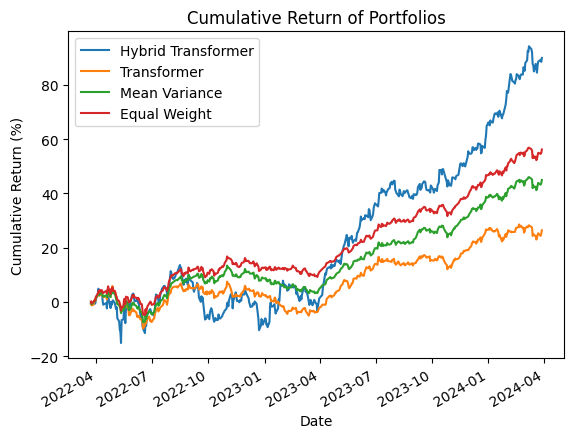

In [ ]:
(returns.cumsum() * 100).plot()
plt.legend(['Hybrid Transformer', 'Transformer', 'Mean Variance', 'Equal Weight'])
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return of Portfolios')
plt.show()

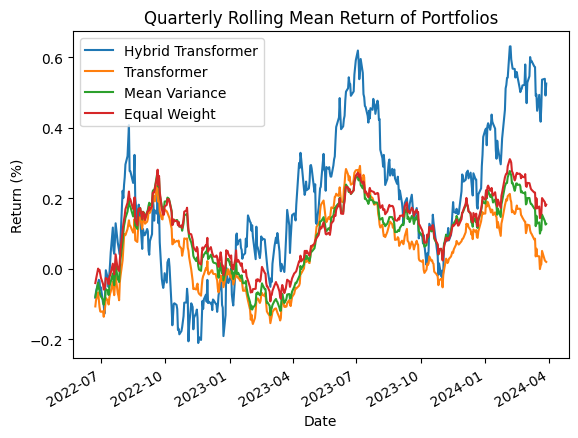

In [ ]:
(returns.rolling(63).mean() * 100).plot()
plt.legend(['Hybrid Transformer', 'Transformer', 'Mean Variance', 'Equal Weight'])
plt.ylabel('Return (%)')
plt.title('Quarterly Rolling Mean Return of Portfolios')
plt.show()

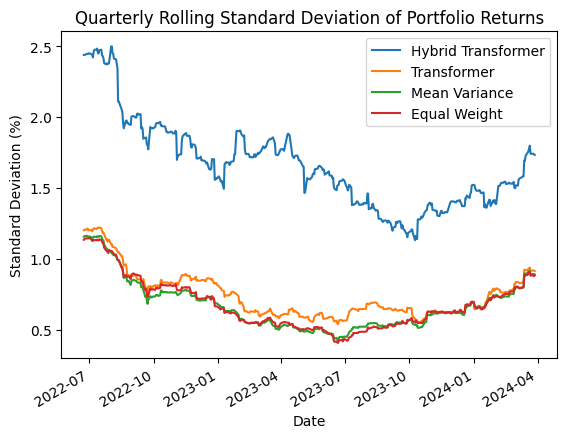

In [ ]:
(returns.rolling(63).std() * 100).plot()
plt.legend(['Hybrid Transformer', 'Transformer', 'Mean Variance', 'Equal Weight'])
plt.ylabel('Standard Deviation (%)')
plt.title('Quarterly Rolling Standard Deviation of Portfolio Returns')
plt.show()

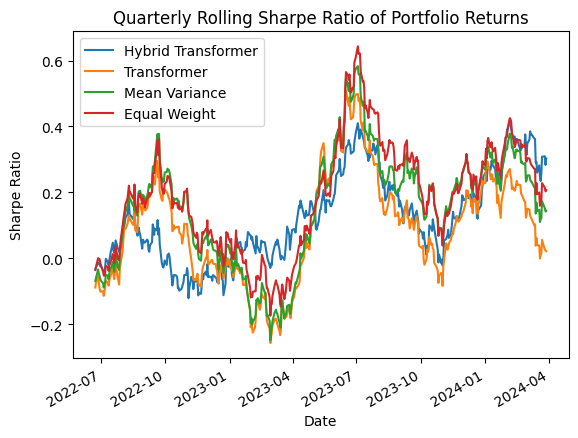

In [ ]:
(returns.rolling(63).mean() / returns.rolling(63).std()).plot()
plt.legend(['Hybrid Transformer', 'Transformer', 'Mean Variance', 'Equal Weight'])
plt.ylabel('Sharpe Ratio')
plt.title('Quarterly Rolling Sharpe Ratio of Portfolio Returns')
plt.show()